In [1]:
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from network.mynetwork import Unet
from loss.loss import CLIPLoss
from utils.func import get_features,vgg_normalize

import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

lr1 = 0.0004
lr2 = 0.0002
model = Unet(device).to(device)
# model = Unet().to(device)
cliploss = CLIPLoss(device)
mseloss = torch.nn.MSELoss()
vgg = torchvision.models.vgg19(pretrained=True).features.to(device)
for x in vgg.parameters():
    x.requires_grad = False

topil = transforms.ToPILImage()
topic = transforms.ToTensor()

dir_lambda = 500
content_lambda = 150
patch_lambda = 9000
norm_lambda = 0.002
gol_lambda = 300

patch_size = 128
patch_num = 3

In [3]:
loss_li = []


In [4]:
def train(iteration1, iteration2, pic, source, target):
    input = pic

    # pic_f = get_features(vgg_normalize(pic), vgg)
    # print(model.parameters())
    opt = optim.Adam(model.parameters(), lr=lr1)
    for i in range(iteration1):
        opt.zero_grad()
        neo_pic = model(input)
        loss = mseloss(pic, neo_pic) * 1

        # loss = 0
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        loss.backward()
        opt.step()

        print("iter:", i + 1, "loss:", loss.item())

        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 50) == 0:
        #     pil.save(f"./pic1/{(i + 1) // 50}.jpg")
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


    # torch.save(model,'unet.pth')

    # model = torch.load('unet.pth')

    pic_f = get_features(vgg_normalize(pic),vgg)

    opt = optim.Adam(model.parameters(), lr=lr2)
    opt_loss = optim.Adam(cliploss.parameters(), lr=lr1)
    for i in range(iteration2):


        opt.zero_grad()
        # neo_pic = model(input)


        patch_points = cliploss.random_patch_points(pic.shape,patch_num,patch_size)
        src_patches = cliploss.generate_patches(pic, patch_points, patch_size)
        target_patches = model(src_patches)

        dir_loss = 0
        dir_loss += cliploss.forward_dir(src_patches, source, target_patches, target)

        gol_loss = 0
        gol_loss += cliploss.forward_gol(src_patches, source, target_patches, target)

        content_loss = 0
        # content_loss += mseloss(pic, neo_pic)
        # neo_pic_f = get_features(vgg_normalize(neo_pic), vgg)
        # content_loss += torch.mean((pic_f['conv4_2'] - neo_pic_f['conv4_2']) ** 2)
        # content_loss += torch.mean((pic_f['conv5_2'] - neo_pic_f['conv5_2']) ** 2)

        patch_loss = 0
        # patch_loss += cliploss.forward_patch(pic, source, neo_pic, target)

        norm_loss = 0
        # norm_loss += cliploss.get_image_prior_losses(target_patches)

        loss = dir_loss * dir_lambda + \
               content_loss * content_lambda + \
               patch_loss * patch_lambda + \
               norm_loss * norm_lambda + \
               gol_loss * gol_lambda

        loss.backward()
        opt.step()
        opt_loss.step()

        loss_li.append(loss.item())

        print("iter:", i + 1, "loss:", loss.item())


        # pil = topil(neo_pic.squeeze(0).cpu())
        # if ((i + 1) % 10) == 0:
        #     pil.save(f"./pic2/{(i + 1) // 10}.jpg")

    # return  model(input)
    # neo_pic = model(input)
    # pil = topil(neo_pic.squeeze(0).cpu())
    # # pil.save(f"{source}-{target}.jpg")
    # pil.save(path)


In [5]:
pil = Image.open(f"source_pic/in14.png")
ori_size = pil.size[::-1]
pil = transforms.Resize(size=(512, 512), interpolation=Image.BICUBIC)(pil)
pic = topic(pil).unsqueeze(0).to(device)
# pic = torch.ones(1, 3, 512, 512).to(device)
pic.requires_grad = False

source = "photo"
target = "Van Gogh"
# target = "the scream by Edvard Munch"
path = "result1.jpg"

In [6]:
start = time.time()
train(100, 100, pic, source, target)
end = time.time()
usetime = end - start
print(f"usetime: {usetime}")

iter: 1 loss: 0.052002936601638794
iter: 2 loss: 0.025567658245563507
iter: 3 loss: 0.016507789492607117
iter: 4 loss: 0.011446977034211159
iter: 5 loss: 0.007951455190777779
iter: 6 loss: 0.005896480288356543
iter: 7 loss: 0.004632997792214155
iter: 8 loss: 0.0038736702408641577
iter: 9 loss: 0.003386877477169037
iter: 10 loss: 0.0030879718251526356
iter: 11 loss: 0.002906596288084984
iter: 12 loss: 0.002806995762512088
iter: 13 loss: 0.002743720542639494
iter: 14 loss: 0.002672059228643775
iter: 15 loss: 0.0025814154651015997
iter: 16 loss: 0.002454255474731326
iter: 17 loss: 0.0023104040883481503
iter: 18 loss: 0.0021971389651298523
iter: 19 loss: 0.002093168441206217
iter: 20 loss: 0.002008413430303335
iter: 21 loss: 0.0019224894931539893
iter: 22 loss: 0.0018553484696894884
iter: 23 loss: 0.0017784459050744772
iter: 24 loss: 0.0017080018296837807
iter: 25 loss: 0.0016390345990657806
iter: 26 loss: 0.0015848614275455475
iter: 27 loss: 0.0015331122558563948
iter: 28 loss: 0.00148513

In [7]:
neo_pic = model(pic)
pil = topil(neo_pic.squeeze(0).cpu())
pil = transforms.Resize(size=ori_size, interpolation=Image.BICUBIC)(pil)
pil.save(path)



# 186.4968602657318


In [8]:
with open(file = "neo.txt", mode = "w") as file:
    for i in loss_li:
        file.write(str(i)+" ")


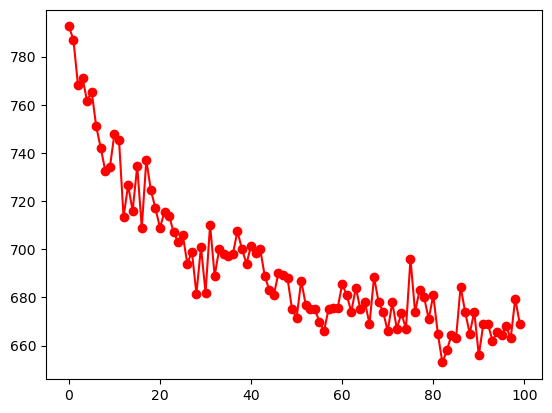

In [9]:
import matplotlib.pyplot as plt

x = [i for i in range(100)]
plt.plot(x,loss_li,color="red",marker="o")
